In [306]:
import matplotlib.pyplot as plt
import numpy as np 
import pandas as pd 
import os
from astropy.constants import c
from astropy import constants as const
import astropy.units as u
from scipy import special


def weight(n):
    return 2 * n**2

def boltzmann(n1, n2, eV, T):
    k = 8.6173303e-5  # Boltzmann constant in eV/K
    g_n = weight(n2) / weight(n1) * np.exp(-eV / (k * T))
    return g_n

def CIV(T):
    sigma_Lya = 5.9e-14 * (T / 1e4) ** (-1/2)
    sigma_CIV = (0.19 / 0.4164) * sigma_Lya * (12) ** (0.5)
    N_CIV_0 = 1 / sigma_CIV
    return sigma_Lya, sigma_CIV, N_CIV_0

sig_ly, sig_c, N_CIV_0 = CIV(1e5)
print("{:.5e}".format(N_CIV_0))

def tau(sig_c, x):
    return sig_c * x

rr = np.arange(12, 18, 1)
atom = [13,20,32,50,79]


C_IV_K = 1548.187e-8  # cm
C_IV_H = 1550.772e-8  # cm
cc = c.to(u.cm / u.s).value  # cm/s
cc_k = c.to(u.km / u.s).value #km / s
v_th_CIV = 11.7673179819719e5  # cm/s

K_gamma = 2.65e+8
H_gamma = 2.64e+8
f_CIV_K = 0.190
f_CIV_H = 0.0952


NN = int(1e4)
xx = np.linspace(-5, 5, NN)
yy = np.linspace(-10,10, NN)



def Voigt(x,v_th,gamma_line, lines):
    del_lam_D = v_th / lines
    a = gamma_line / (4 * np.pi * del_lam_D)
    dy = np.abs(yy[1] - yy[0])
    
    # Broadcasting and vectorized computation
    qq_minus_yy_squared = (x[:, np.newaxis] - yy)**2
    exp_neg_yy_squared = np.exp(-yy**2)
    
    summ = np.sum(exp_neg_yy_squared * dy / (qq_minus_yy_squared + a**2), axis=1)
    
    return summ * a / np.pi

def change_x_to_lam(x,v_th ,lines):
    del_lam_D = v_th / lines
    return lines / (x * v_th / cc + 1)



def N_esc_scat(v_th):
    C_iv_N = np.linspace(1e12, 1e17, NN)
    # total_tau = np.zeros((len(C_iv_N), 1e6))

    # 벡터화된 tau 및 Voigt 프로파일 계산
    Voigt_profile = Voigt(xx,v_th,K_gamma, C_IV_K)
    tau_profile = tau(sig_c, C_iv_N[:, None]) * Voigt_profile


    # x_0 계산
    x_0 = np.zeros(len(C_iv_N))
    for ii, jj in enumerate(C_iv_N):
        x_p = np.where(np.diff(np.sign(1 - tau_profile[ii, :])))[0]
        x_0[ii] = xx[x_p].max() if x_p.size > 0 else 0

    del_lam_D = v_th / C_IV_K
    nu_0_K= cc/C_IV_K
    nu_esc = x_0*del_lam_D + nu_0_K
    V_del_peak = 2 * abs((nu_esc - nu_0_K)/nu_0_K) * cc/1e5 #km/s
    v_esc = x_0*v_th
    N_esc= 1/special.erfc(v_esc/v_th)

    return C_iv_N, N_esc , V_del_peak

C_IV_K_A = 1548.187  # cm
C_IV_H_A = 1550.772
directory_1 = '/home/jin/data_CIV/'

random_vel= [11.8,30,50,100,150]

rr = np.arange(12, 17, 1, dtype=np.float128)
atom_N = [13,20,32,50,79]
total_N_c = np.outer(10**rr, atom_N) / 10
total_N_c = total_N_c.flatten()

check = 0
v_th_CIV = 11.7673179819719e5  # cm/s

3.39090e+13


In [566]:
check = 0

for tt,v_ran in enumerate(random_vel):
    n = 0
    if v_ran == 11.8 :
        index_v_ran = 1
        v_title = int(v_ran*10)
        v_ran = int(v_ran*10)
    elif v_ran < 100:
        index_v_ran = 1
        v_title = int(v_ran*10)
    elif v_ran >= 1000:
        index_v_ran = 3
        v_title = int(v_ran/10)
    else :
        index_v_ran = 2
        v_title = int(v_ran)
        
    globals()[f'tot_V_K_peak_{v_ran}'] = np.zeros(len(rr)*len(atom_N))
    globals()[f'V_H_peak_{v_ran}'] = np.zeros(len(rr)*len(atom_N))
    globals()[f'tot_scat_{v_ran}'] = np.zeros(len(rr)*len(atom_N))
    globals()[f'tot_xx_{v_ran}']= np.zeros(len(rr)*len(atom_N))
    iou = 1e5
    sig_ly, sig_c, N_CIV_0 = CIV(iou)
    globals()[f'tot_C_iv_{v_ran}'],globals()[f'tot_N_scat_{v_ran}'],globals()[f'tot_V_del_peak_{v_ran}'] = N_esc_scat(random_vel[tt]*1e5)

    for ii, index in enumerate(rr):
        index = int(index)
        for jj, atom in enumerate(atom_N):
            atom = int(atom)
            path_sp = f'{directory_1}N_atom{atom}0E+{index}_Vexp000E+00_Vemit100E+00_tauD000E+00_Vran{v_title}E+0{index_v_ran}spec_com.dat'
            path_scat = f'{directory_1}N_atom{atom}0E+{index}_Vexp000E+00_Vemit100E+00_tauD000E+00_Vran{v_title}E+0{index_v_ran}_f_esc.dat'

            try:
                data_sp = pd.read_csv(path_sp, sep='\s+', header=None)
                data_scat = pd.read_csv(path_scat, sep='\s+', header=None)
            except FileNotFoundError:
                print(f"파일을 찾을 수 없습니다: {path_sp}")
                check += 1
                continue

            globals()[f'data_scat_{atom}_{index}_{v_ran}'] = pd.read_csv(path_scat, sep='\s+', header=None)
            
            globals()[f'tot_scat_{v_ran}'][n] = float(globals()[f'data_scat_{atom}_{index}_{v_ran}'].iloc[0,4])
            
            # Read data
            globals()[f'data_tot_sp_{atom}_{index}_{v_ran}'] = pd.read_csv(path_sp, sep='\s+', header=None)
            globals()[f'tot_sp_dlam_{atom}_{index}_{v_ran}'] = globals()[f'data_tot_sp_{atom}_{index}_{v_ran}'][0]
            globals()[f'tot_sp_{atom}_{index}_{v_ran}'] = globals()[f'data_tot_sp_{atom}_{index}_{v_ran}'][1]

            # K and H line separate
            lam_c = (C_IV_K_A + C_IV_H_A) / 2
            # K line
            globals()[f'tot_lambda_K_{atom}_{index}_{v_ran}'] = globals()[f'tot_sp_dlam_{atom}_{index}_{v_ran}'][globals()[f'tot_sp_dlam_{atom}_{index}_{v_ran}'] <= lam_c]
            globals()[f'tot_flux_K_{atom}_{index}_{v_ran}'] = globals()[f'tot_sp_{atom}_{index}_{v_ran}'][globals()[f'tot_sp_dlam_{atom}_{index}_{v_ran}'] <= lam_c]
            # H line
            globals()[f'tot_lambda_H_{atom}_{index}_{v_ran}'] = globals()[f'tot_sp_dlam_{atom}_{index}_{v_ran}'][globals()[f'tot_sp_dlam_{atom}_{index}_{v_ran}'] >= lam_c]
            globals()[f'tot_flux_H_{atom}_{index}_{v_ran}'] = globals()[f'tot_sp_{atom}_{index}_{v_ran}'][globals()[f'tot_sp_dlam_{atom}_{index}_{v_ran}'] >= lam_c]

            # K line double peak separate

            Fraction = 0 #0.000018
            C_IV_K_P = C_IV_K_A +  C_IV_K_A*Fraction 
            C_IV_K_N = C_IV_K_A  -  C_IV_K_A*Fraction 

            X_K_P = globals()[f'tot_lambda_K_{atom}_{index}_{v_ran}'][globals()[f'tot_lambda_K_{atom}_{index}_{v_ran}'] >= C_IV_K_P ].to_numpy()
            X_K_N = globals()[f'tot_lambda_K_{atom}_{index}_{v_ran}'][globals()[f'tot_lambda_K_{atom}_{index}_{v_ran}'] <= C_IV_K_N].to_numpy()
            filtered_series_K_pos_1 = globals()[f'tot_flux_K_{atom}_{index}_{v_ran}'][globals()[f'tot_lambda_K_{atom}_{index}_{v_ran}'] >= C_IV_K_P ].to_numpy()
            filtered_series_K_neg_1 = globals()[f'tot_flux_K_{atom}_{index}_{v_ran}'][globals()[f'tot_lambda_K_{atom}_{index}_{v_ran}'] <= C_IV_K_N].to_numpy()

            tt_K = (globals()[f'tot_lambda_K_{atom}_{index}_{v_ran}'] <= C_IV_K_N) | (globals()[f'tot_lambda_K_{atom}_{index}_{v_ran}'] >= C_IV_K_P )

            globals()[f'tot_x_K_{atom}_{index}_{v_ran}'] = np.compress(tt_K, globals()[f'tot_lambda_K_{atom}_{index}_{v_ran}'])
            globals()[f'tot_y_K_{atom}_{index}_{v_ran}'] = np.compress(tt_K, globals()[f'tot_flux_K_{atom}_{index}_{v_ran}'])

            # H line double peak separate
            C_IV_H_P = C_IV_H_A +  C_IV_H_A*Fraction 
            C_IV_H_N = C_IV_H_A -  C_IV_H_A*Fraction 

            X_H_P = globals()[f'tot_lambda_H_{atom}_{index}_{v_ran}'][globals()[f'tot_lambda_H_{atom}_{index}_{v_ran}'] >= C_IV_H_P].to_numpy()
            X_H_N = globals()[f'tot_lambda_H_{atom}_{index}_{v_ran}'][globals()[f'tot_lambda_H_{atom}_{index}_{v_ran}'] <= C_IV_H_N].to_numpy()
            filtered_series_H_pos_1 = globals()[f'tot_flux_H_{atom}_{index}_{v_ran}'][globals()[f'tot_lambda_H_{atom}_{index}_{v_ran}'] >= C_IV_H_P].to_numpy()
            filtered_series_H_neg_1 = globals()[f'tot_flux_H_{atom}_{index}_{v_ran}'][globals()[f'tot_lambda_H_{atom}_{index}_{v_ran}'] <= C_IV_H_N].to_numpy()

            tt_H = (globals()[f'tot_lambda_H_{atom}_{index}_{v_ran}'] <= C_IV_H_N) | (globals()[f'tot_lambda_H_{atom}_{index}_{v_ran}'] >= C_IV_H_P)

            globals()[f'tot_x_H_{atom}_{index}_{v_ran}'] = np.compress(tt_H, globals()[f'tot_lambda_H_{atom}_{index}_{v_ran}'])
            globals()[f'tot_y_H_{atom}_{index}_{v_ran}'] = np.compress(tt_H, globals()[f'tot_flux_H_{atom}_{index}_{v_ran}'])

            # Get peak indices
            K_p_1 = np.argmax(filtered_series_K_pos_1)
            K_n_1 = np.argmax(filtered_series_K_neg_1)

            H_p_1 = np.argmax(filtered_series_H_pos_1)
            H_n_1 = np.argmax(filtered_series_H_neg_1)

            lam_K_R = X_K_P[K_p_1]
            lam_K_B = X_K_N[K_n_1]
            
            lam_H_R = X_H_P[H_p_1]
            lam_H_B = X_H_P[H_n_1]

            Dlam = lam_K_R - lam_K_B
            vv = v_ran * 1e4

            # if vv / v_th_CIV < 1.2:
            #     dK_H = (1548.218 - 1548.156) * 1.5 
            # else:
            #     dK_H = (1548.218 - 1548.156) * 0.85 
            dK_H = 0.1
            if Dlam <= dK_H:
                del_V_peak_K = 0
            else:
                del_V_peak_K = (Dlam / C_IV_K_A) * cc / 1e5     

            globals()[f'tot_V_K_peak_{v_ran}'][n] = del_V_peak_K
            globals()[f'tot_xx_{v_ran}'][n] = 10**index * atom / 10
            n += 1

print(check)


0


In [567]:
def voigt(lambda_x, v_th, line_K, line_gamma_K, f_K):
    delta_D = v_th / line_K  #1/s

    a = line_gamma_K / (np.pi * 4 * delta_D) 

    yy_x = np.arange(-1, 1, 0.00001)
    dy = abs(yy_x[1] - yy_x[0])
    sol = np.zeros(len(lambda_x))
    x_K = np.zeros(len(lambda_x))

    # Precompute exp(-yy_x^2) since it doesn't depend on xx
    exp_u = np.exp(-yy_x**2)

    # Calculate x_K array for all lambda_x values at once
    for ii, xx in enumerate(lambda_x):
        x = (1 / (xx * 1e-8) - 1 / line_K) * cc / delta_D
        exp_d = (x - yy_x)**2 + a**2
        exp = exp_u / exp_d
        F_lamb = np.sum(exp) * dy

        sol[ii] = F_lamb
        x_K[ii] = x

    return x_K, sol * a / np.pi, delta_D

0.0


(1547.0, 1549.0)

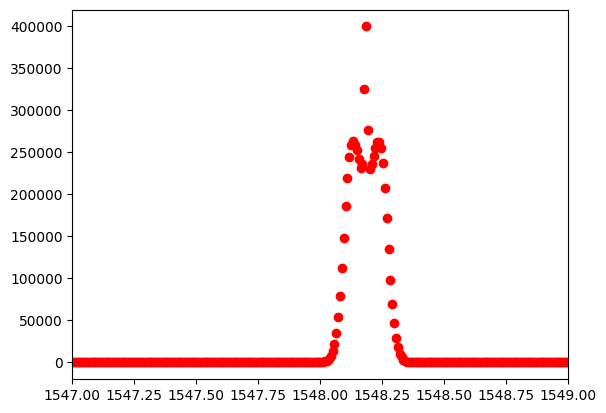

In [806]:

atom_n, index , vran = 79,13,118
plt.plot(globals()[f'tot_x_K_{atom_n}_{index}_{vran}'],globals()[f'tot_y_K_{atom_n}_{index}_{vran}'],'ro')
# plt.xlim(1548,1549)
dx = globals()[f'tot_x_K_{atom_n}_{index}_{vran}']
dy = globals()[f'tot_y_K_{atom_n}_{index}_{vran}']
tau_1 = tau(sig_c,atom_n / 10 * 10 ** index) 

xp,HV,delx = voigt(dx ,v_th_CIV, C_IV_K, K_gamma,f_CIV_K)
# tau_1 = tau(sig_c,total_N_c) 
tt = (tau_1* HV) 
yy = np.exp(-tt)
jj = (1-yy) *1e7
test_y = dy - jj
Fc = dy[1:10].mean()
# pp = np.where(test_y < 0)[0]
print(Fc)
# plt.plot(dx[pp],dy[pp],'ko')
# plt.plot(dx,jj,'bo')
# plt.plot(dx,test_y,'bo')
# plt.plot(globals()[f'tot_x_K_{atom_n}_{index}_{vran}'],globals()[f'tot_y_K_{atom_n}_{index}_{vran}'],'ro')
# plt.axvline(x=C_IV_K_A,ymin=0,ymax=10e7,linestyle='--',color='k')
# plt.axvline(x=C_IV_K_A-0.01,ymin=0,ymax=10e7,linestyle='--',color='r')
# plt.axvline(x=C_IV_K_A+0.01,ymin=0,ymax=10e7,linestyle='--',color='g')
plt.xlim(1547,1549)

In [755]:
def delta_func(x,x_0, ee):
    to = (x-x_0)**2 / ee**2 
    sol = np.exp(-to/2)/ np.sqrt(2*np.pi*ee**2)
    norf = sol.max()
    return sol /norf

def down_resolution(dx,dy,pp):
    newx= np.array([])
    newy = np.array([])
    for ii in np.arange(0,len(dx)-pp , pp):
        xx = dx[ii:ii+pp].mean()
        yy = dy[ii:ii+pp].mean()
        newx = np.append(xx,newx)
        newy = np.append(yy,newy)
    return newx, newy 

In [807]:
sol = delta_func(dx,C_IV_K_A,2e-2)

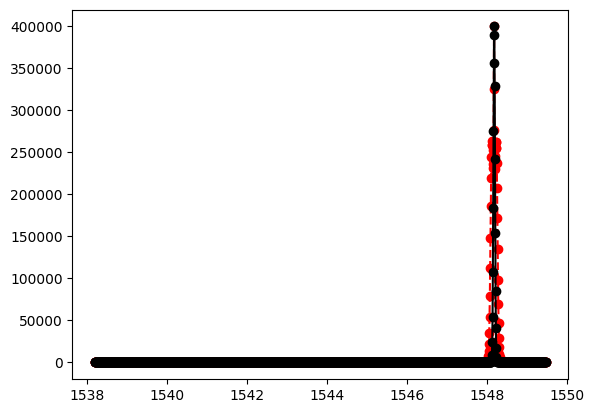

In [808]:
sol = delta_func(dx,C_IV_K_A,2e-2)
Fp = (dy.max()+0.5)
dd = dy - sol*Fp
nn = np.where(dd < 0)
dx = globals()[f'tot_x_K_{atom_n}_{index}_{vran}']
dy = globals()[f'tot_y_K_{atom_n}_{index}_{vran}']
# plt.plot(dx,sol*Fp)
plt.plot(dx,dy,'ro--')
plt.plot(dx,sol*Fp,'ko-')

(array([1225, 1226, 1227, 1228, 1229, 1230, 1231, 1232, 1233, 1234, 1235,
       1236, 1237, 1238, 1239, 1240, 1241, 1242, 1243, 1244, 1245, 1246,
       1247, 1248, 1249, 1250, 1251, 1252, 1253, 1254, 1255, 1256, 1257,
       1258, 1259, 1260, 1261, 1262, 1263, 1264, 1265, 1266, 1267, 1268,
       1269, 1270, 1271, 1272, 1273, 1274, 1275, 1276, 1277, 1278, 1279,
       1280, 1281, 1282, 1283, 1284, 1285, 1286, 1287, 1288, 1289, 1290,
       1291, 1292, 1293, 1295, 1325, 1326, 1327, 1328, 1329, 1330, 1360,
       1361, 1362, 1363, 1364, 1365, 1366, 1367, 1368, 1369, 1370, 1371,
       1372, 1373, 1374, 1375, 1376, 1377, 1378, 1379, 1380, 1381, 1382,
       1383, 1384, 1385, 1386, 1387, 1388, 1389, 1390, 1391, 1392, 1393,
       1394, 1395, 1396, 1397, 1398, 1399, 1400, 1401, 1402, 1403, 1404,
       1405, 1406, 1407, 1408, 1409, 1410, 1411, 1412, 1413, 1414, 1415,
       1416, 1417, 1418, 1419, 1420, 1421, 1422, 1423, 1424, 1425, 1426,
       1427, 1428, 1429]),)


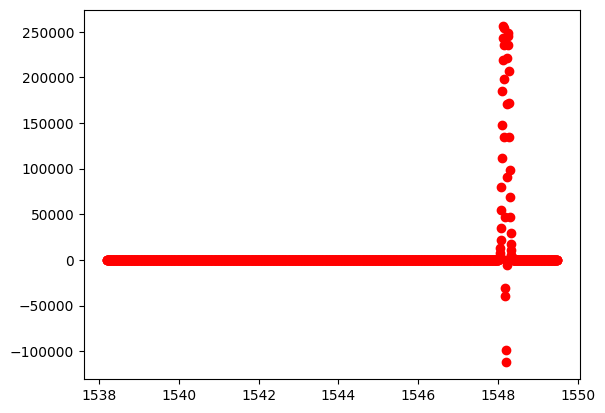

In [809]:
dd = dy - sol*Fp
nn = np.where(dd < 0)
print(nn)
plt.plot(dx,dd,'ro')

In [810]:
dx = globals()[f'tot_x_K_{atom_n}_{index}_{vran}']
dy = globals()[f'tot_y_K_{atom_n}_{index}_{vran}']
tesx = np.delete(dx,nn)
tesy = np.delete(dy,nn)

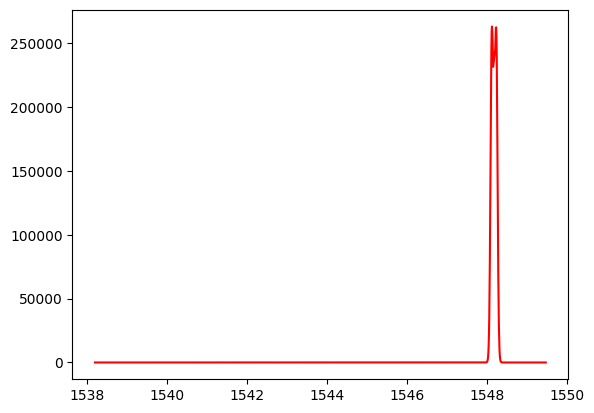

In [816]:
plt.plot(tesx,tesy,'r-')
xx, yy = down_resolution(tesx,tesy,3)

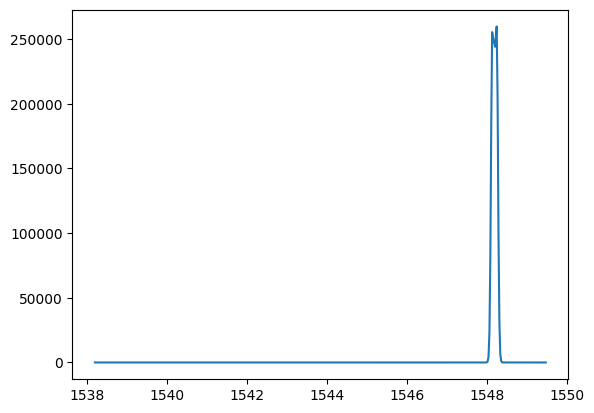

In [817]:
plt.plot(xx,yy)

(1547.0, 1549.0)

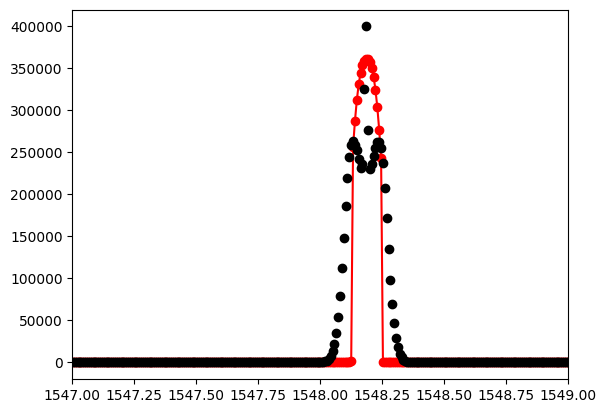

In [666]:
plt.plot(dx,jj/25,'ro-')
plt.plot(globals()[f'tot_x_K_{atom_n}_{index}_{vran}'],globals()[f'tot_y_K_{atom_n}_{index}_{vran}'],'ko')
# plt.ylim(0,5e5)
plt.xlim(1547,1549)

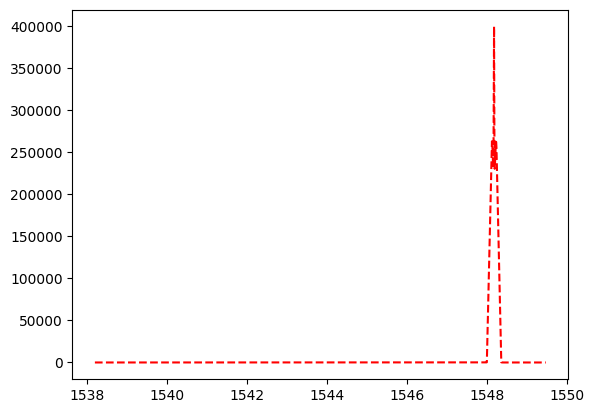

In [634]:
# dx = np.delete(dx,pp)
# dy = np.delete(dy,pp)
plt.plot(dx,dy,'r--')

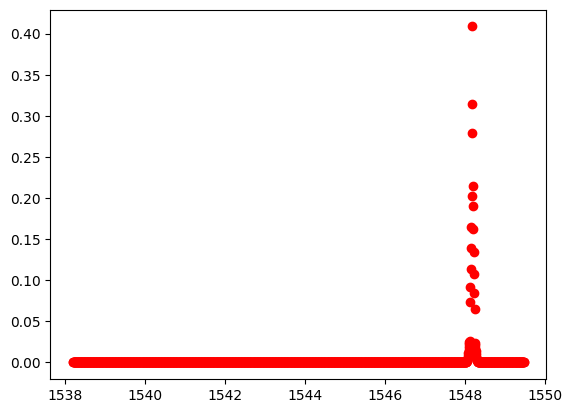

In [577]:
plt.plot(dx,test_y,'ro')
# plt.yscale('log')

In [548]:
pp = np.where(abs(test_y)<2e6)
pp

(array([1323, 1325, 1326, 1327, 1328, 1329, 1330, 1331, 1332]),)

In [137]:
x_lam

array([1548.182  , 1548.18201, 1548.18202, ..., 1548.23698, 1548.23699,
       1548.237  ])

In [162]:
aa = np.array([C_IV_K_A])
xp, K, delx = voigt(x_lam ,v_th_CIV, C_IV_K, K_gamma,f_CIV_K)


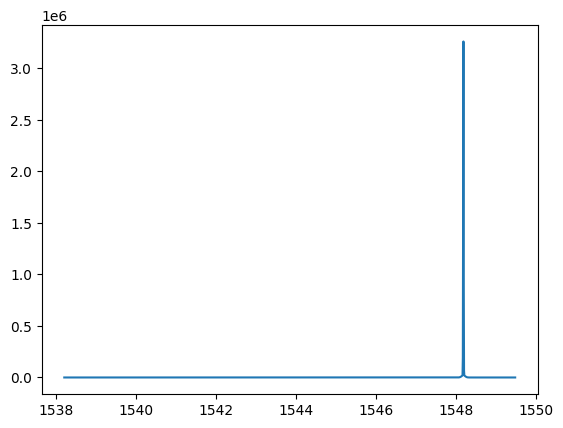

In [142]:
plt.plot(globals()[f'tot_x_K_{atom_n}_{index}_{vran}'],globals()[f'tot_y_K_{atom_n}_{index}_{vran}'])
# plt.yscale()

/tmp/ipykernel_3834/3320728478.py:3: UserWarning: Attempt to set non-positive ylim on a log-scaled axis will be ignored.
  plt.ylim(0,1)


(-10.0, 10.0)

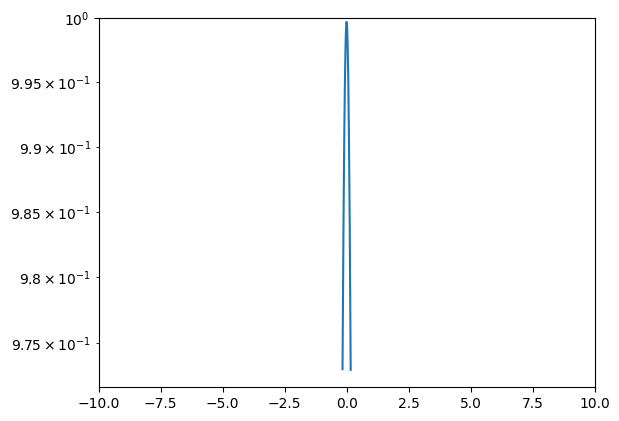

In [169]:


plt.plot(xp,K)
plt.yscale('log')
plt.ylim(0,1)
plt.xlim(-10,10)

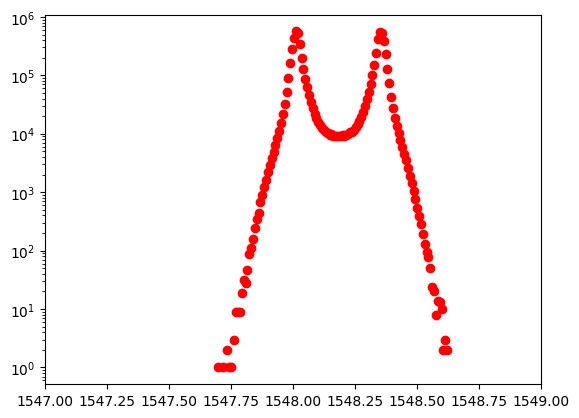

In [410]:
atom_n, index , vran = 79,16,118
plt.plot(globals()[f'tot_x_K_{atom_n}_{index}_{vran}'],globals()[f'tot_y_K_{atom_n}_{index}_{vran}'],'ro')
plt.xlim(1547,1549)
x_lam = globals()[f'tot_x_K_{atom_n}_{index}_{vran}']
tau_1 = tau(sig_c,total_N_c) 



# plt.plot(x_lam,yy_1)
plt.yscale('log')

In [411]:
x_lam = np.arange(C_IV_K_A-0.018,C_IV_K_A+0.018,0.00001)
dx = globals()[f'tot_x_K_{atom_n}_{index}_{vran}']
xp, K, delx = voigt(x_lam ,v_th_CIV, C_IV_K, K_gamma,f_CIV_K)
tt = tau(sig_c,total_N_c)
tau_1 = tau(sig_c,total_N_c[-1]) 


xp,HV,delx = voigt(dx ,v_th_CIV, C_IV_K, K_gamma,f_CIV_K)
# tau_1 = tau(sig_c,total_N_c) 

In [405]:
tau_1

np.longdouble('2329.7676258453408038')

0.9999887800975858361


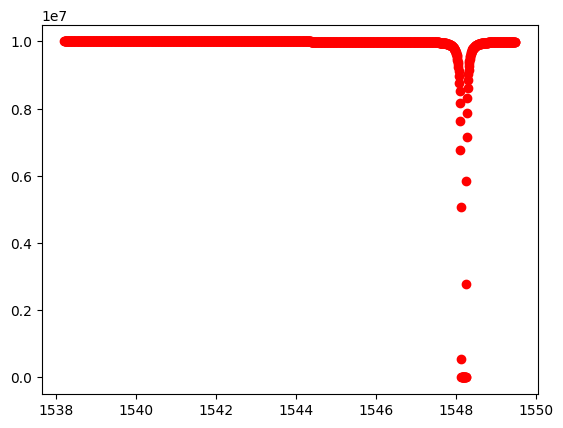

In [412]:
xp,HV,delx = voigt(dx ,v_th_CIV, C_IV_K, K_gamma,f_CIV_K)
# tau_1 = tau(sig_c,total_N_c) 
tt = (tau_1* HV) 
yy = np.exp(-tt)
jj = (yy) *1e7

plt.plot(dx,jj,'ro')
dl = jj.max() - jj.min()
print(dl/1e7)

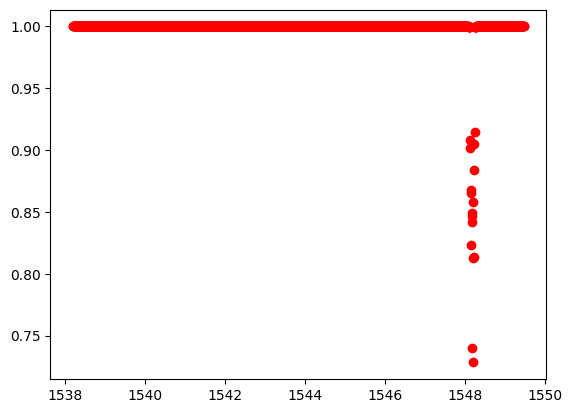

In [528]:
atom_n, index , vran = 79,12,118
dx = globals()[f'tot_x_K_{atom_n}_{index}_{vran}']
xp, K, delx = voigt(x_lam ,v_th_CIV, C_IV_K, K_gamma,f_CIV_K)
tau_1 = tau(sig_c,atom_n*10**index/10)
# tau_1 = tau(sig_c,total_N_c[0]) 


xp,HV,delx = voigt(dx ,v_th_CIV, C_IV_K, K_gamma,f_CIV_K)
xp,HV,delx = voigt(dx ,v_th_CIV, C_IV_K, K_gamma,f_CIV_K)
# tau_1 = tau(sig_c,total_N_c) 
tt = (tau_1* HV) 
yy = np.exp(-tt)
jj = (yy) 

plt.plot(dx,jj,'ro')
dl = jj.max() - jj.min()
# print(dl/1e7)

pp = np.where(jj < 0.99e7)[0]
dy = globals()[f'tot_y_K_{atom_n}_{index}_{vran}']
# xp,HV,delx = voigt(dx ,v_th_CIV, C_IV_K, K_gamma,f_CIV_K)
# jj 배열에서 pp 인덱스에 해당하는 요소를 삭제합니다.
jj = np.delete(jj, pp)
dx = np.delete(dx,pp)
dy = np.delete(dy,pp)
# plt.yscale('log')

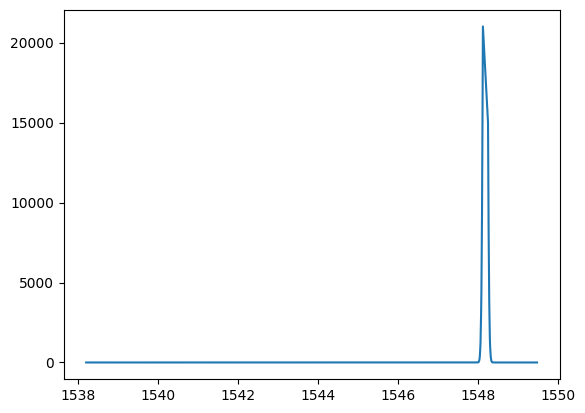

In [466]:
plt.plot(dx,dy)

In [459]:
xp,HV,delx = voigt(dx ,v_th_CIV, C_IV_K, K_gamma,f_CIV_K)
# tau_1 = tau(sig_c,total_N_c) 
tt = (tau_1 * HV) 
yy = np.exp(-tt)
jj = (yy) *1e7
pp = np.where(jj < 0.98e7)[0]
dy = globals()[f'tot_y_K_{atom_n}_{index}_{vran}']
# xp,HV,delx = voigt(dx ,v_th_CIV, C_IV_K, K_gamma,f_CIV_K)
# jj 배열에서 pp 인덱스에 해당하는 요소를 삭제합니다.
jj = np.delete(jj, pp)
dx = np.delete(dx,pp)
dy = np.delete(dy,pp)
# jj = np.delete(pp,jj)
# pp =4
# newx = np.array([])
# newy = np.array([])
# for ii in np.arange(0,len(dx)-pp , pp):
#     xx = dx[ii:ii+pp].mean()
#     yy = dy[ii:ii+pp].mean()
#     newx = np.append(xx,newx)
#     newy = np.append(yy,newy)



TypeError: 'float' object is not subscriptable

In [310]:
def down_resolution(xx,yy,pp):
    newx= np.array([])
    newy = np.array([])
    for ii in np.arange(0,len(dx)-pp , pp):
        xx = dx[ii:ii+pp].mean()
        yy = dy[ii:ii+pp].mean()
        newx = np.append(xx,newx)
        newy = np.append(yy,newy)
    return newx, newy 

In [328]:
dx = globals()[f'tot_x_K_{atom_n}_{index}_{vran}']
dy = globals()[f'tot_y_K_{atom_n}_{index}_{vran}']

xx ,yy = down_resolution(dx,dy,pp)


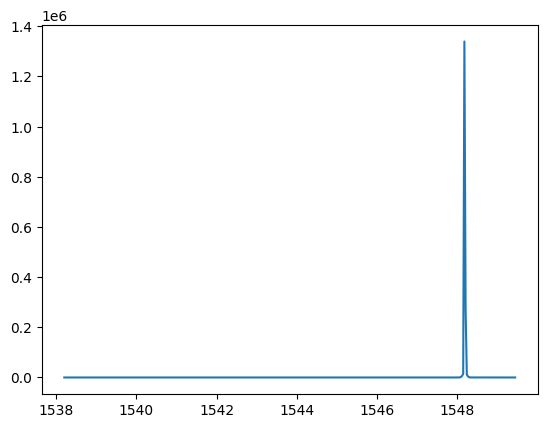

In [329]:
plt.plot(xx,yy)

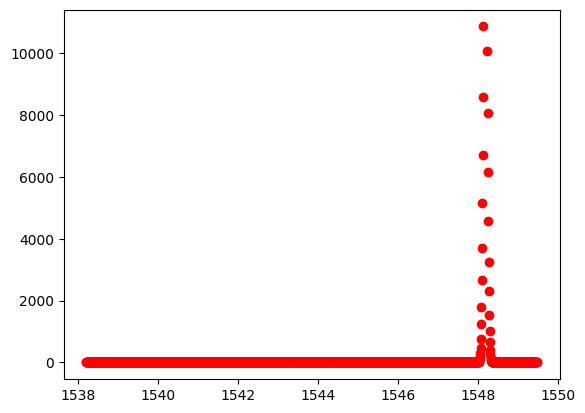

In [304]:
plt.plot(dx,dy,'ro')

pp =4
newx = np.array([])
newy = np.array([])
for ii in np.arange(0,len(dx)-pp , pp):
    xx = dx[ii:ii+pp].mean()
    yy = dy[ii:ii+pp].mean()
    newx = np.append(xx,newx)
    newy = np.append(yy,newy)


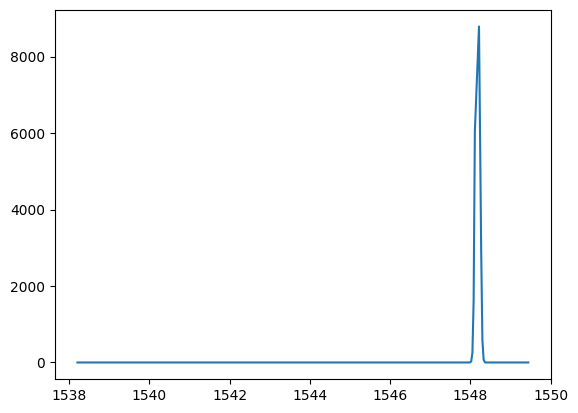

In [305]:
plt.plot(newx,newy)

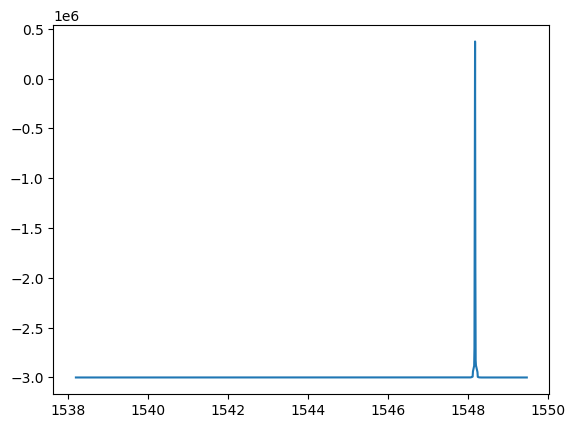

In [259]:
plt.plot(dx,dy-jj)

In [191]:
tau_1 = tau(sig_c,total_N_c) 
gg = tau_1[0]


np.longdouble('0.03833794827340434234')

In [236]:
tau_1 = tau(sig_c,total_N_c) 
gg = tau_1[0]
dy = np.zeros(len(dx))
new_x = np.array([])
new_y = np.array([])
yy = globals()[f'tot_y_K_{atom_n}_{index}_{vran}']
for ii, xx in enumerate(dx):
    if xx >= x_lam[0] and xx <= x_lam[-1]:
        aa = np.array([xx])
        xp,HV,delx = voigt(aa ,v_th_CIV, C_IV_K, K_gamma,f_CIV_K)
        tt = gg*HV 
        fy = np.exp(-tt)*1e7
        a = fy

    else: a = 0

    yla = yy[ii] - a
    if yla < 0 :
        print(ii)
    else : x= 1
    


1325
1326
1327
1328
1329


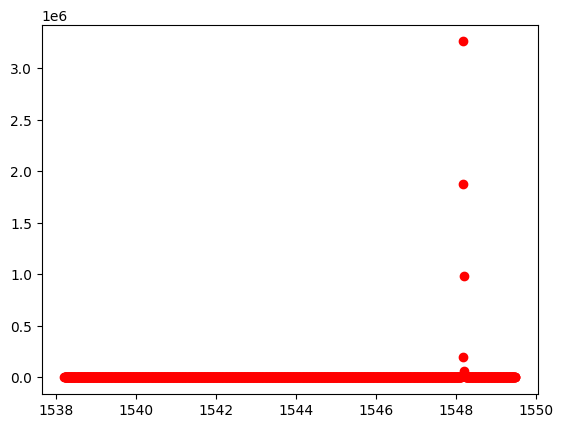

In [235]:
plt.plot(dx,yy,'ro')

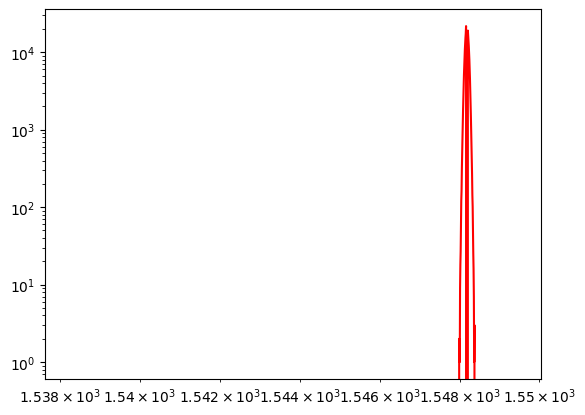

In [230]:
yy = globals()[f'tot_y_K_{atom_n}_{index}_{vran}']
plt.loglog(dx,yy- dy,'r')
# plt.yscale('log')
# plt.ylim(0,1e4)

In [316]:
tau_o = tau(sig_c,10**12)
tau_o 

0.029490729441080263

In [330]:
def voigt(lambda_x, v_th, line_K, line_gamma_K, f_K):
    delta_D = v_th / line_K  #1/s

    a = line_gamma_K / (np.pi * 4 * delta_D) 

    yy_x = np.arange(-1, 1, 0.001)
    dy = abs(yy_x[1] - yy_x[0])
    sol = np.zeros(len(lambda_x))
    x_K = np.zeros(len(lambda_x))

    # Precompute exp(-yy_x^2) since it doesn't depend on xx
    exp_u = np.exp(-yy_x**2)

    # Calculate x_K array for all lambda_x values at once
    for ii, xx in enumerate(lambda_x):
        x = (1 / (xx * 1e-8) - 1 / line_K) * cc / delta_D
        exp_d = (x - yy_x)**2 + a**2
        exp = exp_u / exp_d
        F_lamb = np.sum(exp) * dy

        sol[ii] = F_lamb
        x_K[ii] = x

    return x_K, sol * a / np.pi, delta_D

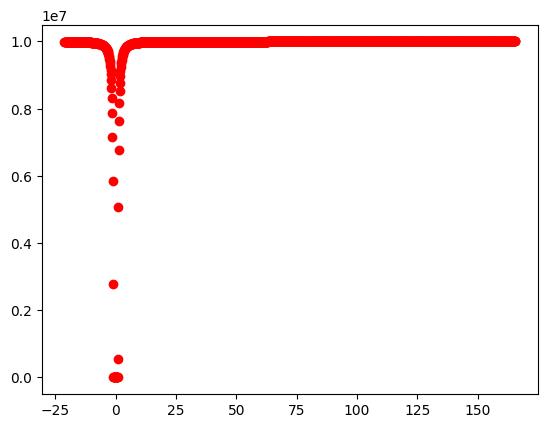

In [340]:
xp,HV,delx = voigt(dx ,v_th_CIV, C_IV_K, K_gamma,f_CIV_K)
yy = np.exp(-tau_o*HV)*1e7
plt.plot(xp,yy,'ro')
# plt.yscale('log')

In [508]:
check = 0

for tt,v_ran in enumerate(random_vel):
    n = 0
    if v_ran == 11.8 :
        index_v_ran = 1
        v_title = int(v_ran*10)
        v_ran = int(v_ran*10)
    elif v_ran < 100:
        index_v_ran = 1
        v_title = int(v_ran*10)
    elif v_ran >= 1000:
        index_v_ran = 3
        v_title = int(v_ran/10)
    else :
        index_v_ran = 2
        v_title = int(v_ran)
        
    globals()[f'tot_V_K_peak_{v_ran}'] = np.zeros(len(rr)*len(atom_N))
    globals()[f'V_H_peak_{v_ran}'] = np.zeros(len(rr)*len(atom_N))
    globals()[f'tot_scat_{v_ran}'] = np.zeros(len(rr)*len(atom_N))
    globals()[f'tot_xx_{v_ran}']= np.zeros(len(rr)*len(atom_N))
    iou = 1e5
    sig_ly, sig_c, N_CIV_0 = CIV(iou)
    globals()[f'tot_C_iv_{v_ran}'],globals()[f'tot_N_scat_{v_ran}'],globals()[f'tot_V_del_peak_{v_ran}'] = N_esc_scat(random_vel[tt]*1e5)

    for ii, index in enumerate(rr):
        index = int(index)
        for jj, atom in enumerate(atom_N):
            atom = int(atom)
            path_sp = f'{directory_1}N_atom{atom}0E+{index}_Vexp000E+00_Vemit100E+00_tauD000E+00_Vran{v_title}E+0{index_v_ran}spec_com.dat'
            path_scat = f'{directory_1}N_atom{atom}0E+{index}_Vexp000E+00_Vemit100E+00_tauD000E+00_Vran{v_title}E+0{index_v_ran}_f_esc.dat'

            try:
                data_sp = pd.read_csv(path_sp, sep='\s+', header=None)
                data_scat = pd.read_csv(path_scat, sep='\s+', header=None)
            except FileNotFoundError:
                print(f"파일을 찾을 수 없습니다: {path_sp}")
                check += 1
                continue

            globals()[f'data_scat_{atom}_{index}_{v_ran}'] = pd.read_csv(path_scat, sep='\s+', header=None)
            
            globals()[f'tot_scat_{v_ran}'][n] = float(globals()[f'data_scat_{atom}_{index}_{v_ran}'].iloc[0,4])
            
            # Read data
            globals()[f'data_tot_sp_{atom}_{index}_{v_ran}'] = pd.read_csv(path_sp, sep='\s+', header=None)
            globals()[f'tot_sp_dlam_{atom}_{index}_{v_ran}'] = globals()[f'data_tot_sp_{atom}_{index}_{v_ran}'][0]
            globals()[f'tot_sp_{atom}_{index}_{v_ran}'] = globals()[f'data_tot_sp_{atom}_{index}_{v_ran}'][1]

            # K and H line separate
            lam_c = (C_IV_K_A + C_IV_H_A) / 2
            # K line
            globals()[f'tot_lambda_K_{atom}_{index}_{v_ran}'] = globals()[f'tot_sp_dlam_{atom}_{index}_{v_ran}'][globals()[f'tot_sp_dlam_{atom}_{index}_{v_ran}'] <= lam_c]
            globals()[f'tot_flux_K_{atom}_{index}_{v_ran}'] = globals()[f'tot_sp_{atom}_{index}_{v_ran}'][globals()[f'tot_sp_dlam_{atom}_{index}_{v_ran}'] <= lam_c]
            # H line
            globals()[f'tot_lambda_H_{atom}_{index}_{v_ran}'] = globals()[f'tot_sp_dlam_{atom}_{index}_{v_ran}'][globals()[f'tot_sp_dlam_{atom}_{index}_{v_ran}'] >= lam_c]
            globals()[f'tot_flux_H_{atom}_{index}_{v_ran}'] = globals()[f'tot_sp_{atom}_{index}_{v_ran}'][globals()[f'tot_sp_dlam_{atom}_{index}_{v_ran}'] >= lam_c]

            # K line double peak separate
            column_d = atom*10**index / 10
            tau_o = tau(sig_c,column_d )

            x_K,VH_K,del_K = voigt(globals()[f'tot_lambda_K_{atom}_{index}_{v_ran}'] ,random_vel[tt]*1e5, C_IV_K, K_gamma,f_CIV_K)
            x_H,VH_H,del_H = voigt(globals()[f'tot_lambda_H_{atom}_{index}_{v_ran}'] ,random_vel[tt]*1e5, C_IV_H, H_gamma,f_CIV_H)

            y_K = np.exp(-tau_o * VH_K) *1e7
            y_H = np.exp(-tau_o * VH_H) *1e7
            
            del_K = (y_K.max() - y_K.min())/1e7
            del_H = (y_H.max() - y_H.min()) /1e7
            
            if  del_K  < 0.85 : 
                rem_K = np.where(y_K < 0.9995e7)[0]
                globals()[f'tot_x_K_{atom}_{index}_{v_ran}'] = np.delete( globals()[f'tot_lambda_K_{atom}_{index}_{v_ran}'],rem_K)
                globals()[f'tot_y_K_{atom}_{index}_{v_ran}'] = np.delete( globals()[f'tot_flux_K_{atom}_{index}_{v_ran}'],rem_K)
            else :
                globals()[f'tot_x_K_{atom}_{index}_{v_ran}'] = globals()[f'tot_lambda_K_{atom}_{index}_{v_ran}']
                globals()[f'tot_y_K_{atom}_{index}_{v_ran}'] = globals()[f'tot_flux_K_{atom}_{index}_{v_ran}']


            if del_H  < 0.85 : 

                rem_H = np.where(y_H < 0.9995e7)[0]
                globals()[f'tot_x_H_{atom}_{index}_{v_ran}'] = np.delete( globals()[f'tot_lambda_H_{atom}_{index}_{v_ran}'],rem_H)
                globals()[f'tot_y_H_{atom}_{index}_{v_ran}'] = np.delete( globals()[f'tot_flux_H_{atom}_{index}_{v_ran}'],rem_H)
            else :
                globals()[f'tot_x_H_{atom}_{index}_{v_ran}'] = globals()[f'tot_lambda_H_{atom}_{index}_{v_ran}']
                globals()[f'tot_y_H_{atom}_{index}_{v_ran}'] = globals()[f'tot_flux_H_{atom}_{index}_{v_ran}']
            # Get peak indices

            # lam_K_R
            # Dlam = lam_K_R - lam_K_B
            # vv = v_ran * 1e5

            # dK_H = 0.1
            # if Dlam <= dK_H:
            #     del_V_peak_K = 0
            # else:
            #     del_V_peak_K = (Dlam / C_IV_K_A) * cc / 1e5     

            # globals()[f'tot_V_K_peak_{v_ran}'][n] = del_V_peak_K
            # globals()[f'tot_xx_{v_ran}'][n] = 10**index * atom / 10
            # n += 1

print(check)


0


In [414]:
def down_resolution(dx,dy,pp):
    newx= np.array([])
    newy = np.array([])
    for ii in np.arange(0,len(dx)-pp , pp):
        xx = dx[ii:ii+pp].mean()
        yy = dy[ii:ii+pp].mean()
        newx = np.append(xx,newx)
        newy = np.append(yy,newy)
    return newx, newy 

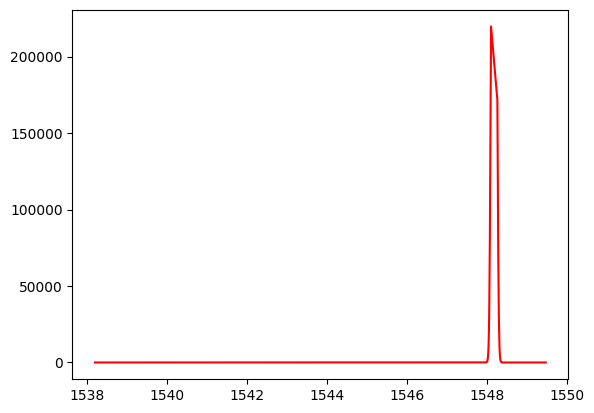

In [512]:
atom, index , v_ran = 79, 13, 118

plt.plot( globals()[f'tot_x_K_{atom}_{index}_{v_ran}'], globals()[f'tot_y_K_{atom}_{index}_{v_ran}'],'r-')
# plt.xlim(15)
# xx, yy = down_resolution(globals()[f'tot_x_H_{atom}_{index}_{v_ran}'], globals()[f'tot_y_H_{atom}_{index}_{v_ran}'],3)

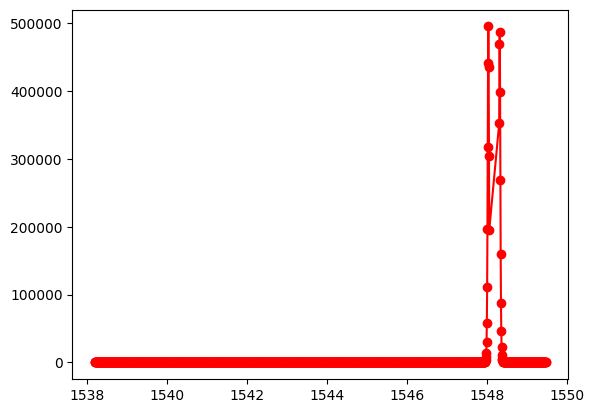

In [394]:
atom, index , v_ran = 79 , 15 , 118

plt.plot( globals()[f'tot_x_K_{atom}_{index}_{v_ran}'], globals()[f'tot_y_K_{atom}_{index}_{v_ran}'],'ro-')
xx, yy = down_resolution(globals()[f'tot_x_K_{atom}_{index}_{v_ran}'], globals()[f'tot_y_K_{atom}_{index}_{v_ran}'],3)

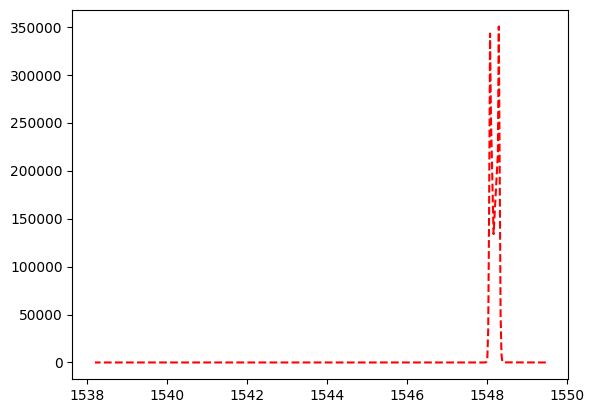

In [384]:
plt.plot(xx,yy,'r--')

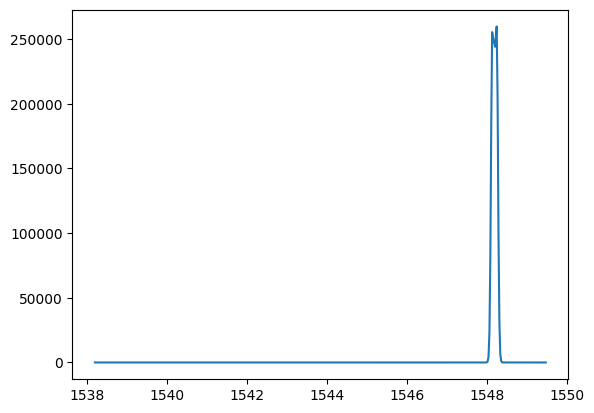

In [818]:
plt.plot(xx,yy)

In [901]:
import matplotlib.pyplot as plt
import numpy as np 
import pandas as pd 
import os
from astropy.constants import c
from astropy import constants as const
import astropy.units as u
from scipy import special


def weight(n):
    return 2 * n**2

def boltzmann(n1, n2, eV, T):
    k = 8.6173303e-5  # Boltzmann constant in eV/K
    g_n = weight(n2) / weight(n1) * np.exp(-eV / (k * T))
    return g_n

def CIV(T):
    sigma_Lya = 5.9e-14 * (T / 1e4) ** (-1/2)
    sigma_CIV = (0.19 / 0.4164) * sigma_Lya * (12) ** (0.5)
    N_CIV_0 = 1 / sigma_CIV
    return sigma_Lya, sigma_CIV, N_CIV_0

sig_ly, sig_c, N_CIV_0 = CIV(1e5)
print("{:.5e}".format(N_CIV_0))

def tau(sig_c, x):
    return sig_c * x

rr = np.arange(12, 18, 1)
# ee = np.arange(0,725,25)
# em = np.arange(25,725,25)
# em = np.append(1,em)
# random_v = np.arange(250,7250,250)
# random_v = np.append(118,random_v)
atom = [13,20,32,50,79]


rr_reshaped = rr.reshape(-1, 1)
total_N_c = 10**rr_reshaped * atom / 10
total_N_c = total_N_c.flatten()

C_IV_K = 1548.187e-8  # cm
C_IV_H = 1550.772e-8  # cm
cc = c.to(u.cm / u.s).value  # cm/s
cc_k = c.to(u.km / u.s).value #km / s
v_th_CIV = 11.7673179819719e5  # cm/s

K_gamma = 2.65e+8
H_gamma = 2.64e+8
f_CIV_K = 0.190
f_CIV_H = 0.0952


NN = int(1e4)
xx = np.linspace(-5, 5, NN)
yy = np.linspace(-10,10, NN)



def Voigt(x,v_th,gamma_line, lines):
    del_lam_D = v_th / lines
    a = gamma_line / (4 * np.pi * del_lam_D)
    dy = np.abs(yy[1] - yy[0])
    
    # Broadcasting and vectorized computation
    qq_minus_yy_squared = (x[:, np.newaxis] - yy)**2
    exp_neg_yy_squared = np.exp(-yy**2)
    
    summ = np.sum(exp_neg_yy_squared * dy / (qq_minus_yy_squared + a**2), axis=1)
    
    return summ * a / np.pi

def change_x_to_lam(x,v_th ,lines):
    del_lam_D = v_th / lines
    return lines / (x * v_th / cc + 1)



def N_esc_scat(v_th):
    C_iv_N = np.linspace(1e12, 1e17, NN)
    # total_tau = np.zeros((len(C_iv_N), 1e6))

    # 벡터화된 tau 및 Voigt 프로파일 계산
    Voigt_profile = Voigt(xx,v_th,K_gamma, C_IV_K)
    tau_profile = tau(sig_c, C_iv_N[:, None]) * Voigt_profile


    # x_0 계산
    x_0 = np.zeros(len(C_iv_N))
    for ii, jj in enumerate(C_iv_N):
        x_p = np.where(np.diff(np.sign(1 - tau_profile[ii, :])))[0]
        x_0[ii] = xx[x_p].max() if x_p.size > 0 else 0

    del_lam_D = v_th / C_IV_K
    nu_0_K= cc/C_IV_K
    nu_esc = x_0*del_lam_D + nu_0_K
    V_del_peak = 2 * abs((nu_esc - nu_0_K)/nu_0_K) * cc/1e5 #km/s
    v_esc = x_0*v_th
    N_esc= 1/special.erfc(v_esc/v_th)

    return C_iv_N, N_esc , V_del_peak

C_IV_K_A = 1548.187  # cm
C_IV_H_A = 1550.772
directory_1 = '/home/jin/data_CIV/'

random_vel= [11.8,30,50,100,150]

rr = np.arange(12, 17, 1, dtype=np.float128)
atom_N = [13,20,32,50,79]
total_N_c = np.outer(10**rr, atom_N) / 10
total_N_c = total_N_c.flatten()

check = 0
v_th_CIV = 11.7673179819719e5  # cm/s

def down_resolution(dx,dy,pp):
    newx= np.array([])
    newy = np.array([])
    for ii in np.arange(0,len(dx)-pp , pp):
        xx = dx[ii:ii+pp].mean()
        yy = dy[ii:ii+pp].mean()
        newx = np.append(xx,newx)
        newy = np.append(yy,newy)
    return newx, newy 

def delta_func(x,x_0, ee):
    to = (x-x_0)**2 / ee**2 
    sol = np.exp(-to/2)/ np.sqrt(2*np.pi*ee**2)
    norf = sol.max()
    return sol /norf

def find_inflection_points(x, y):
    # 1차 미분을 통해 변화율 계산
    dydx = np.gradient(y, x)
    # 2차 미분으로 변곡점 계산 (변화율이 바뀌는 지점)
    inflection_points = np.where(np.diff(np.sign(dydx)))[0]
    return inflection_points if inflection_points.size > 0 else None




3.39090e+13


In [904]:
def find_inflection_points(x, y):
    # 2차 도함수 계산
    second_derivative = np.diff(np.sign(np.diff(y)))

    # 변곡점이 발생한 인덱스
    inflection_points = np.where(second_derivative != 0)[0] + 1

    # 해당 변곡점의 x 값 반환
    if len(inflection_points) > 0:
        return x[inflection_points]
    else:
        return None

In [907]:
check = 0


directory_1 = '/home/jin/data_CIV/'

random_vel= [11.8,30,50,100,150]

rr = np.arange(12, 17, 1, dtype=np.float128)
atom_N = [13,20,32,50,79]
total_N_c = np.outer(10**rr, atom_N) / 10
total_N_c = total_N_c.flatten()

for tt,v_ran in enumerate(random_vel):
    n = 0
    if v_ran == 11.8 :
        index_v_ran = 1
        v_title = int(v_ran*10)
        v_ran = int(v_ran*10)
    elif v_ran < 100:
        index_v_ran = 1
        v_title = int(v_ran*10)
    elif v_ran >= 1000:
        index_v_ran = 3
        v_title = int(v_ran/10)
    else :
        index_v_ran = 2
        v_title = int(v_ran)
        
    globals()[f'tot_V_K_peak_{v_ran}'] = np.zeros(len(rr)*len(atom_N))
    globals()[f'V_H_peak_{v_ran}'] = np.zeros(len(rr)*len(atom_N))
    globals()[f'tot_scat_{v_ran}'] = np.zeros(len(rr)*len(atom_N))
    globals()[f'tot_xx_{v_ran}']= np.zeros(len(rr)*len(atom_N))
    iou = 1e5
    sig_ly, sig_c, N_CIV_0 = CIV(iou)
    globals()[f'tot_C_iv_{v_ran}'],globals()[f'tot_N_scat_{v_ran}'],globals()[f'tot_V_del_peak_{v_ran}'] = N_esc_scat(random_vel[tt]*1e5)

    for ii, index in enumerate(rr):
        index = int(index)
        for jj, atom in enumerate(atom_N):
            atom = int(atom)
            path_sp = f'{directory_1}N_atom{atom}0E+{index}_Vexp000E+00_Vemit100E+00_tauD000E+00_Vran{v_title}E+0{index_v_ran}spec_com.dat'
            path_scat = f'{directory_1}N_atom{atom}0E+{index}_Vexp000E+00_Vemit100E+00_tauD000E+00_Vran{v_title}E+0{index_v_ran}_f_esc.dat'

            try:
                data_sp = pd.read_csv(path_sp, sep='\s+', header=None)
                data_scat = pd.read_csv(path_scat, sep='\s+', header=None)
            except FileNotFoundError:
                print(f"파일을 찾을 수 없습니다: {path_sp}")
                check += 1
                continue

            globals()[f'data_scat_{atom}_{index}_{v_ran}'] = pd.read_csv(path_scat, sep='\s+', header=None)
            
            globals()[f'tot_scat_{v_ran}'][n] = float(globals()[f'data_scat_{atom}_{index}_{v_ran}'].iloc[0,4])
            
            # Read data
            globals()[f'data_tot_sp_{atom}_{index}_{v_ran}'] = pd.read_csv(path_sp, sep='\s+', header=None)
            globals()[f'tot_sp_dlam_{atom}_{index}_{v_ran}'] = globals()[f'data_tot_sp_{atom}_{index}_{v_ran}'][0]
            globals()[f'tot_sp_{atom}_{index}_{v_ran}'] = globals()[f'data_tot_sp_{atom}_{index}_{v_ran}'][1]

            # K and H line separate
            lam_c = (C_IV_K_A + C_IV_H_A) / 2
            # K line
            globals()[f'tot_lambda_K_{atom}_{index}_{v_ran}'] = globals()[f'tot_sp_dlam_{atom}_{index}_{v_ran}'][globals()[f'tot_sp_dlam_{atom}_{index}_{v_ran}'] <= lam_c]
            globals()[f'tot_flux_K_{atom}_{index}_{v_ran}'] = globals()[f'tot_sp_{atom}_{index}_{v_ran}'][globals()[f'tot_sp_dlam_{atom}_{index}_{v_ran}'] <= lam_c]
            # H line
            globals()[f'tot_lambda_H_{atom}_{index}_{v_ran}'] = globals()[f'tot_sp_dlam_{atom}_{index}_{v_ran}'][globals()[f'tot_sp_dlam_{atom}_{index}_{v_ran}'] >= lam_c]
            globals()[f'tot_flux_H_{atom}_{index}_{v_ran}'] = globals()[f'tot_sp_{atom}_{index}_{v_ran}'][globals()[f'tot_sp_dlam_{atom}_{index}_{v_ran}'] >= lam_c]

            # K line double peak separate
            sol = delta_func(globals()[f'tot_lambda_K_{atom}_{index}_{v_ran}'] ,C_IV_K_A,2e-2)
            Fp = (globals()[f'tot_flux_K_{atom}_{index}_{v_ran}'].max()+0.5)
            dd = globals()[f'tot_flux_K_{atom}_{index}_{v_ran}'] - sol*Fp
            nn = np.where(dd < 0)

            globals()[f'tot_x_K_{atom}_{index}_{v_ran}'] = np.delete(globals()[f'tot_lambda_K_{atom}_{index}_{v_ran}'], nn)
            globals()[f'tot_y_K_{atom}_{index}_{v_ran}'] = np.delete(globals()[f'tot_flux_K_{atom}_{index}_{v_ran}'], nn)
            Fraction =0.00002   #0.000018
            # C_IV_K_P = C_IV_K_A +  C_IV_K_A*Fraction 
            # C_IV_K_N = C_IV_K_A  -  C_IV_K_A*Fraction 
            globals()[f'tot_x_K_{atom}_{index}_{v_ran}'], globals()[f'tot_y_K_{atom}_{index}_{v_ran}'] = down_resolution(globals()[f'tot_x_K_{atom}_{index}_{v_ran}'], globals()[f'tot_y_K_{atom}_{index}_{v_ran}'],1)
            X_K_P = globals()[f'tot_x_K_{atom}_{index}_{v_ran}'][globals()[f'tot_x_K_{atom}_{index}_{v_ran}'] >= C_IV_K_A ]
            X_K_N = globals()[f'tot_x_K_{atom}_{index}_{v_ran}'][globals()[f'tot_x_K_{atom}_{index}_{v_ran}'] <= C_IV_K_A]
            filtered_series_K_pos_1 = globals()[f'tot_y_K_{atom}_{index}_{v_ran}'][globals()[f'tot_x_K_{atom}_{index}_{v_ran}'] >= C_IV_K_A ]
            filtered_series_K_neg_1 = globals()[f'tot_y_K_{atom}_{index}_{v_ran}'][globals()[f'tot_x_K_{atom}_{index}_{v_ran}'] <= C_IV_K_A]

            # tt_K = (globals()[f'tot_lambda_K_{atom}_{index}_{v_ran}'] <= C_IV_K_N) | (globals()[f'tot_lambda_K_{atom}_{index}_{v_ran}'] >= C_IV_K_P )

            # globals()[f'tot_x_K_{atom}_{index}_{v_ran}'] = np.compress(tt_K, globals()[f'tot_lambda_K_{atom}_{index}_{v_ran}'])
            # globals()[f'tot_y_K_{atom}_{index}_{v_ran}'] = np.compress(tt_K, globals()[f'tot_flux_K_{atom}_{index}_{v_ran}'])

            # H line double peak separate
            C_IV_H_P = C_IV_H_A +  C_IV_H_A*Fraction 
            C_IV_H_N = C_IV_H_A -  C_IV_H_A*Fraction 

            X_H_P = globals()[f'tot_lambda_H_{atom}_{index}_{v_ran}'][globals()[f'tot_lambda_H_{atom}_{index}_{v_ran}'] >= C_IV_H_P].to_numpy()
            X_H_N = globals()[f'tot_lambda_H_{atom}_{index}_{v_ran}'][globals()[f'tot_lambda_H_{atom}_{index}_{v_ran}'] <= C_IV_H_N].to_numpy()
            filtered_series_H_pos_1 = globals()[f'tot_flux_H_{atom}_{index}_{v_ran}'][globals()[f'tot_lambda_H_{atom}_{index}_{v_ran}'] >= C_IV_H_P].to_numpy()
            filtered_series_H_neg_1 = globals()[f'tot_flux_H_{atom}_{index}_{v_ran}'][globals()[f'tot_lambda_H_{atom}_{index}_{v_ran}'] <= C_IV_H_N].to_numpy()

            tt_H = (globals()[f'tot_lambda_H_{atom}_{index}_{v_ran}'] <= C_IV_H_N) | (globals()[f'tot_lambda_H_{atom}_{index}_{v_ran}'] >= C_IV_H_P)

            globals()[f'tot_x_H_{atom}_{index}_{v_ran}'] = np.compress(tt_H, globals()[f'tot_lambda_H_{atom}_{index}_{v_ran}'])
            globals()[f'tot_y_H_{atom}_{index}_{v_ran}'] = np.compress(tt_H, globals()[f'tot_flux_H_{atom}_{index}_{v_ran}'])


            
            # Get peak indices
            K_p_1 = np.argmax(filtered_series_K_pos_1)
            K_n_1 = np.argmax(filtered_series_K_neg_1)

            H_p_1 = np.argmax(filtered_series_H_pos_1)
            H_n_1 = np.argmax(filtered_series_H_neg_1)

            lam_K_R = X_K_P[K_p_1]
            lam_K_B = X_K_N[K_n_1]
            
            lam_H_R = X_H_P[H_p_1]
            lam_H_B = X_H_P[H_n_1]

            Dlam = lam_K_R - lam_K_B
            vv = v_ran * 1e5


            if v_ran == 118:
                dK_H = 0.12
            else : dK_H = 0.17

            if Dlam <= dK_H:
                del_V_peak_K = 0
            else:
                del_V_peak_K = (Dlam / C_IV_K_A) * cc / 1e5     

            globals()[f'tot_V_K_peak_{v_ran}'][n] = del_V_peak_K
            globals()[f'tot_xx_{v_ran}'][n] = 10**index * atom / 10
            n += 1

print(check)


0


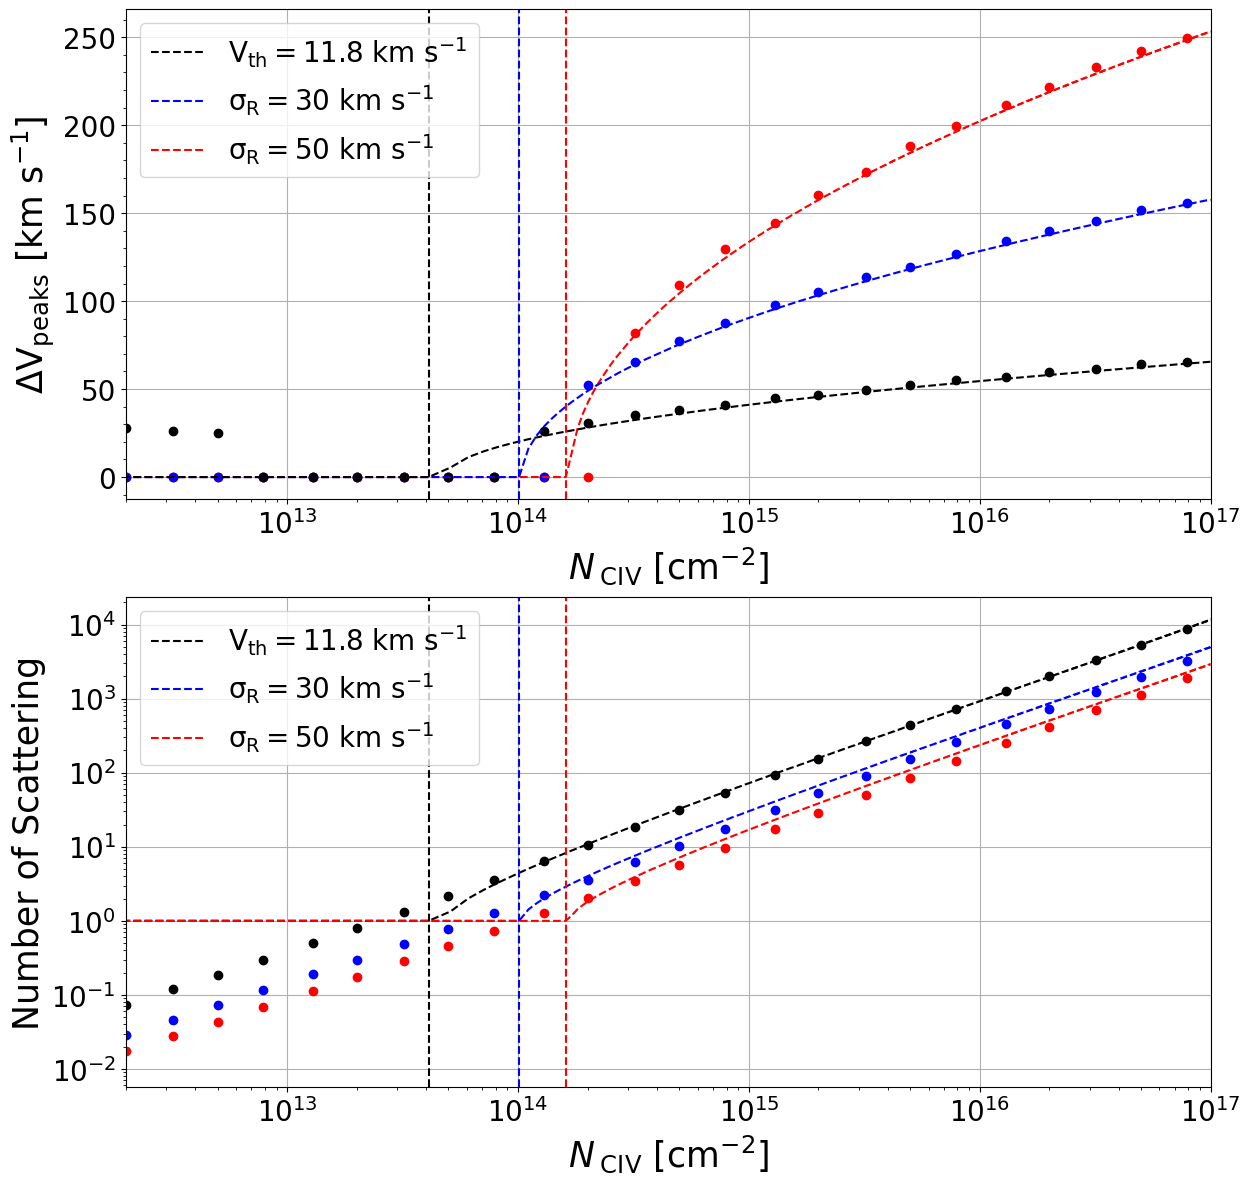

In [908]:
fig = plt.figure(1,figsize=(14,14))

plt.subplot(211)

plt.plot(tot_xx_50,tot_V_K_peak_50,'ro')
plt.plot(tot_xx_30,tot_V_K_peak_30,'bo')
# plt.plot(tot_xx_500,tot_V_K_peak_500,'bo')
plt.plot(tot_xx_118,tot_V_K_peak_118,'ko')

# plt.plot(tot_C_iv_2000,tot_V_del_peak_2000,'r--')
plt.plot(tot_C_iv_50,tot_V_del_peak_50,'r--')
plt.plot(tot_C_iv_30,tot_V_del_peak_30,'b--')
plt.plot(tot_C_iv_118,tot_V_del_peak_118,'k--')

t_1 = np.where(tot_V_del_peak_118 == 0)[0][-1]
t_2 = np.where(tot_V_del_peak_30 == 0)[0][-1]
t_3 = np.where(tot_V_del_peak_50 == 0)[0][-1]

plt.axvline(x=tot_C_iv_118[t_1],ymin=0,ymax=80,color='k',linestyle='--',label='${\mathrm{V_{th}}} = 11.8$ km s$^{-1}$')
plt.axvline(x=tot_C_iv_30[t_2],ymin=0,ymax=80,color='b',linestyle='--',label='${\mathrm{\sigma_{R}}} = 30$ km s$^{-1}$')
plt.axvline(x=tot_C_iv_50[t_3],ymin=0,ymax=80,color='r',linestyle='--',label='${\mathrm{\sigma_{R}}} = 50$ km s$^{-1}$')


# plt.axvline(x=7.58e+13,ymin=0,ymax=80,color='b',linestyle='--',label='${\mathrm{V_{th}}} = 26.3$ km s$^{-1}$')
# plt.axvline(x=1.07230e+14,ymin=0,ymax=80,color='r',linestyle='--',label='${\mathrm{V_{th}}} = 37.2$ km s$^{-1}$')



plt.xlabel(r'${N} \, _{\mathrm{C IV}}$ [cm$^{-2}$]',fontsize =25)
plt.xscale('log')
plt.xlim(2*10**12,10**17)
# plt.ylim(tot_V_K_peak_1.min()-2,tot_V_K_peak_1.max()+2)
plt.ylabel(r'$\Delta \mathrm{V}_{\mathrm{peaks}}$ [km s$^{-1}$]',fontsize =25)
plt.minorticks_on()
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)
plt.grid()
plt.legend(fontsize=20,loc='upper left')

plt.subplot(212)
plt.plot(tot_xx_118,tot_scat_118,'ko')
plt.plot(tot_C_iv_118,tot_N_scat_118,'k--')
# plt.axvline(x=3.39e13,ymin=tot_N_scat_118.min()-10,ymax=2,color='k',linestyle='--',label='${\mathrm{V_{th}}} = 11.8$ km s$^{-1}$')
plt.plot(tot_xx_30,tot_scat_30,'bo')
plt.plot(tot_C_iv_30,tot_N_scat_30,'b--')

plt.plot(tot_xx_50,tot_scat_50,'ro')
plt.plot(tot_C_iv_50,tot_N_scat_50,'r--')
# plt.axvline(x=7.58e13,ymin=tot_N_scat_252.min()-10,ymax=2,color='b',linestyle='--',label='${\mathrm{V_{th}}} = 26.3$ km s$^{-1}$')

# plt.plot(tot_xx_2000,tot_N_scat_2000,'ro')
# plt.plot(tot_C_iv_2000,tot_N_scat_2000,'r--')
# plt.axvline(x=1.07e14,ymin=tot_N_scat_372.min()-10,ymax=2,color='r',linestyle='--',label='${\mathrm{V_{th}}} = 37.2$ km s$^{-1}$')

plt.axvline(x=tot_C_iv_118[t_1],ymin=0,ymax=80,color='k',linestyle='--',label='${\mathrm{V_{th}}} = 11.8$ km s$^{-1}$')
plt.axvline(x=tot_C_iv_30[t_2],ymin=0,ymax=80,color='b',linestyle='--',label='${\mathrm{\sigma_{R}}} = 30$ km s$^{-1}$')
plt.axvline(x=tot_C_iv_50[t_3],ymin=0,ymax=80,color='r',linestyle='--',label='${\mathrm{\sigma_{R}}} = 50$ km s$^{-1}$')


plt.xlabel(r'${N} \, _{\mathrm{C IV}}$ [cm$^{-2}$]',fontsize =25)
plt.xscale('log')
plt.yscale('log')
plt.xlim(2*10**12,10**17)
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)
# plt.ylim(scat.min(),scat.max()+2)
plt.ylabel(r'Number of Scattering',fontsize =25)
plt.minorticks_on()
plt.grid()
plt.legend(fontsize=20,loc='upper left')


# plt.savefig('/home/jin/바탕화면/simulation_vs_analyvic_jin_test.pdf',bbox_inches="tight")



(1547.0, 1549.0)

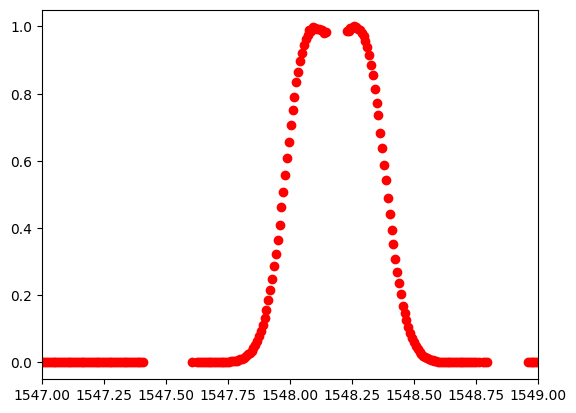

In [909]:
atom , index = 13 , 14
v_ran = 30
# globals()[f'tot_x_H_{atom}_{index}_{v_ran}'] = np.compress(tt_H, globals()[f'tot_lambda_H_{atom}_{index}_{v_ran}'])
#             globals()[f'tot_y_H_{atom}_{index}_{v_ran}']
nor = globals()[f'tot_y_K_{atom}_{index}_{v_ran}'].max()
plt.plot(globals()[f'tot_x_K_{atom}_{index}_{v_ran}'], globals()[f'tot_y_K_{atom}_{index}_{v_ran}']/nor,'ro')
plt.xlim(1547,1549)